### **FINAL PROJECT** - Build a neural network to predict if a patient has pneumonia or not based on X-ray chest

By:

*   Carlos Pérez
*   Sergio Rodríguez
*   Marcos Uceta


### **1) Import everything that we need**

We will do this using Analytic Zoo with Orca.

In [5]:
# Install jdk8
!apt-get install openjdk-8-jre-headless -qq > /dev/null

import os

# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [6]:
# Install latest pre-release version of Analytics Zoo
%%capture
!pip install --pre --upgrade analytics-zoo[ray]

In [7]:
# Our data is storaged in .zip format
import zipfile

# Orca functions
from bigdl.dataset import base
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext
from pathlib import Path

# Needed to transform and plot our data
import cv2
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import torch
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from keras.callbacks import ReduceLROnPlateau

In [8]:
# For image pre-processing
%%capture
!pip install sparkdl

### **2) Pre-processed the images**

To ensure a reliable model, we need to give it reliable data to build it. In this case, we need to pre-processed the images to remove those that can be unreliable.

Filtering out corrupted images in train set:

In [9]:
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 173 images


Filtering out corrupted images in validation set:

In [10]:
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/val", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 6 images


Filtering out corrupted images in test set:

In [11]:
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/test", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 38 images


### **3) Visualize the data**

To do that, first we need to configure some parameters to be able to store and see it.

In [12]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [13]:
train = get_data('/content/train')
test = get_data('/content/test')
val = get_data('/content/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


When we are working with this type of data, that we will use to create machine learning models, it is vital to know with what we are working. Let's see how many images are of normal cases and how much are of pneumonia cases.

In training:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


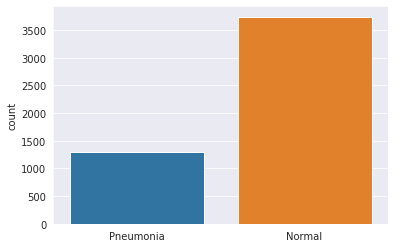

In [14]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

In validation:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


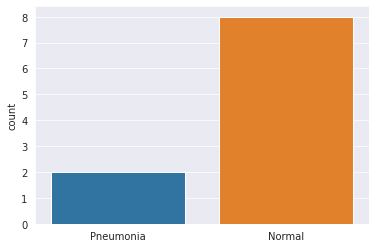

In [15]:
l = []
for i in val:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

In test:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


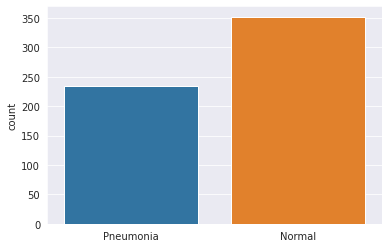

In [16]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

We have a larger number of normal samples than pneumonia samples in training set; while it is quite good distributed in validation and test set. This is important because the better distributed is our data, the better is trained our model.

Let's see how looks the normal samples and the pneumonia samples:

Text(0.5, 1.0, 'PNEUMONIA')

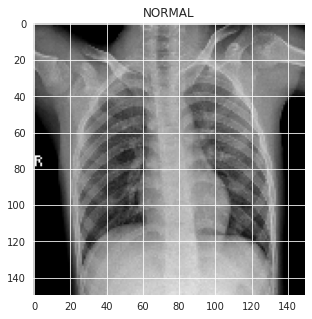

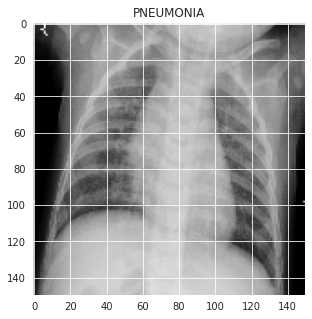

In [17]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

### **4) Load the data and create the train, validation and test sets**

We need to convert it from a directory to a set of images to give it to our model.

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_set = train_datagen.flow_from_directory("/content/train",
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle = True)

Found 5043 images belonging to 2 classes.


In [19]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory("/content/val",
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = True)

Found 10 images belonging to 2 classes.


In [20]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory("/content/test",
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = False)

Found 586 images belonging to 2 classes.


### **5) Build the Convolutional Neural Network**

We are going to use keras to create our neural network.

In [21]:
cnn = tf.keras.models.Sequential()

In [22]:
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu',
                               input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

cnn.add(tf.keras.layers.Dense(units=2, activation='sigmoid'))

In [23]:
cnn.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='sparse_categorical_crossentropy',
            metrics = ['accuracy'])

### **6) Train our model**

In [24]:
cnn.fit(x = train_set, validation_data = val_set, batch_size= 158, epochs = 25)

Epoch 1/25
158/158 [==============================] - 103s 646ms/step - loss: 0.4794 - accuracy: 0.7852 - val_loss: 0.3350 - val_accuracy: 0.9000
Epoch 2/25
158/158 [==============================] - 100s 630ms/step - loss: 0.2838 - accuracy: 0.8842 - val_loss: 0.2158 - val_accuracy: 0.9000
Epoch 3/25
158/158 [==============================] - 100s 632ms/step - loss: 0.2123 - accuracy: 0.9141 - val_loss: 0.0653 - val_accuracy: 1.0000
Epoch 4/25
158/158 [==============================] - 100s 631ms/step - loss: 0.1793 - accuracy: 0.9296 - val_loss: 0.0297 - val_accuracy: 1.0000
Epoch 5/25
158/158 [==============================] - 100s 629ms/step - loss: 0.1747 - accuracy: 0.9300 - val_loss: 0.1979 - val_accuracy: 1.0000
Epoch 6/25
158/158 [==============================] - 99s 625ms/step - loss: 0.1527 - accuracy: 0.9391 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 7/25
158/158 [==============================] - 99s 624ms/step - loss: 0.1496 - accuracy: 0.9431 - val_loss: 0.0430 - v

### **7) Evaluate our model** 

Once we have trained our model, we can evaluate how good it is by evaluating it with the test set.

In [25]:
cnn.evaluate(test_set)

19/19 [==============================] - 7s 336ms/step - loss: 0.4123 - accuracy: 0.9061


[0.4122796356678009, 0.9061433672904968]